# Introduction

L'apprentissage profond, également connu sous le nom de réseau neuronal, a gagné en popularité ces dernières années et est désormais largement utilisé dans de nombreux domaines. L'une de ses applications les plus populaires est la classification d'images, qui utilise le réseau de neurones à convolution (« CNN »)
Dans ce projet nous allons construire un réseau de neurones à convolution qui nous aiderait à diagnostiquer la pneumonie à partir d'images de radiographie

## Import des librairies
Ici on importe les librairies dont on a besoin pour le projet

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import itertools
from sklearn.metrics import accuracy_score
import seaborn as sns
import cv2
from skimage.transform import resize
from keras.applications import VGG16

# Data Preparation and Augmentation

On importe notre dataset qui comprend 5 856 images de radiographie étiquetées comme étant soit "Pneumonie" soit "Normal"
Ces images de radiographie sont réparties en ensembles d'apprentissage, de validation et de test. Il y a 5 216 images dans l'ensemble d'apprentissage, 624 images dans l'ensemble de validation et 16 images dans l'ensemble de test.

In [2]:
base_dir = "/content/drive/MyDrive/ColabNotebooks/chest_Xray/"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_NORMAL_dir = os.path.join(train_dir, "NORMAL")
train_PNEUMONIA_dir = os.path.join(train_dir, "PNEUMONIA")

validation_NORMAL_dir = os.path.join(validation_dir, "NORMAL")
validation_PNEUMONIA_dir = os.path.join(validation_dir, "PNEUMONIA")

test_NORMAL_dir = os.path.join(test_dir, "NORMAL")
test_PNEUMONIA_dir = os.path.join(test_dir, "PNEUMONIA")

train_NORMAL_fnames = os.listdir(train_NORMAL_dir)
train_PNEUMONIA_fnames = os.listdir(train_PNEUMONIA_dir)

validation_NORMAL_fnames = os.listdir(validation_NORMAL_dir)
validation_PNEUMONIA_fnames = os.listdir(validation_PNEUMONIA_dir)

test_NORMAL_fnames = os.listdir(test_NORMAL_dir)
test_PNEUMONIA_fnames = os.listdir(test_PNEUMONIA_dir)

n_train = len(train_NORMAL_fnames) + len(train_PNEUMONIA_fnames)
n_validation = len(validation_NORMAL_fnames) + len(validation_PNEUMONIA_fnames)
n_test = len(test_NORMAL_fnames) + len(test_PNEUMONIA_fnames)

print("Taille du dossier train :", n_train)
print("Taille du dossier val :", n_validation)
print("Taille du dossier test :", n_test)
print("Taille des images Normal du dossier test :", len(test_NORMAL_fnames) )
print("Taille des images Normal du dossier test :", len(test_PNEUMONIA_fnames))

Taille du dossier train : 5216
Taille du dossier val : 16
Taille du dossier test : 624
Taille des images Normal du dossier test : 234
Taille des images Normal du dossier test : 390


Ci-dessous, j'affiche 10 images de radiographie de l'ensemble d'apprentissage, dont 5 sont "Normales" et 5 sont "Pneumonic".

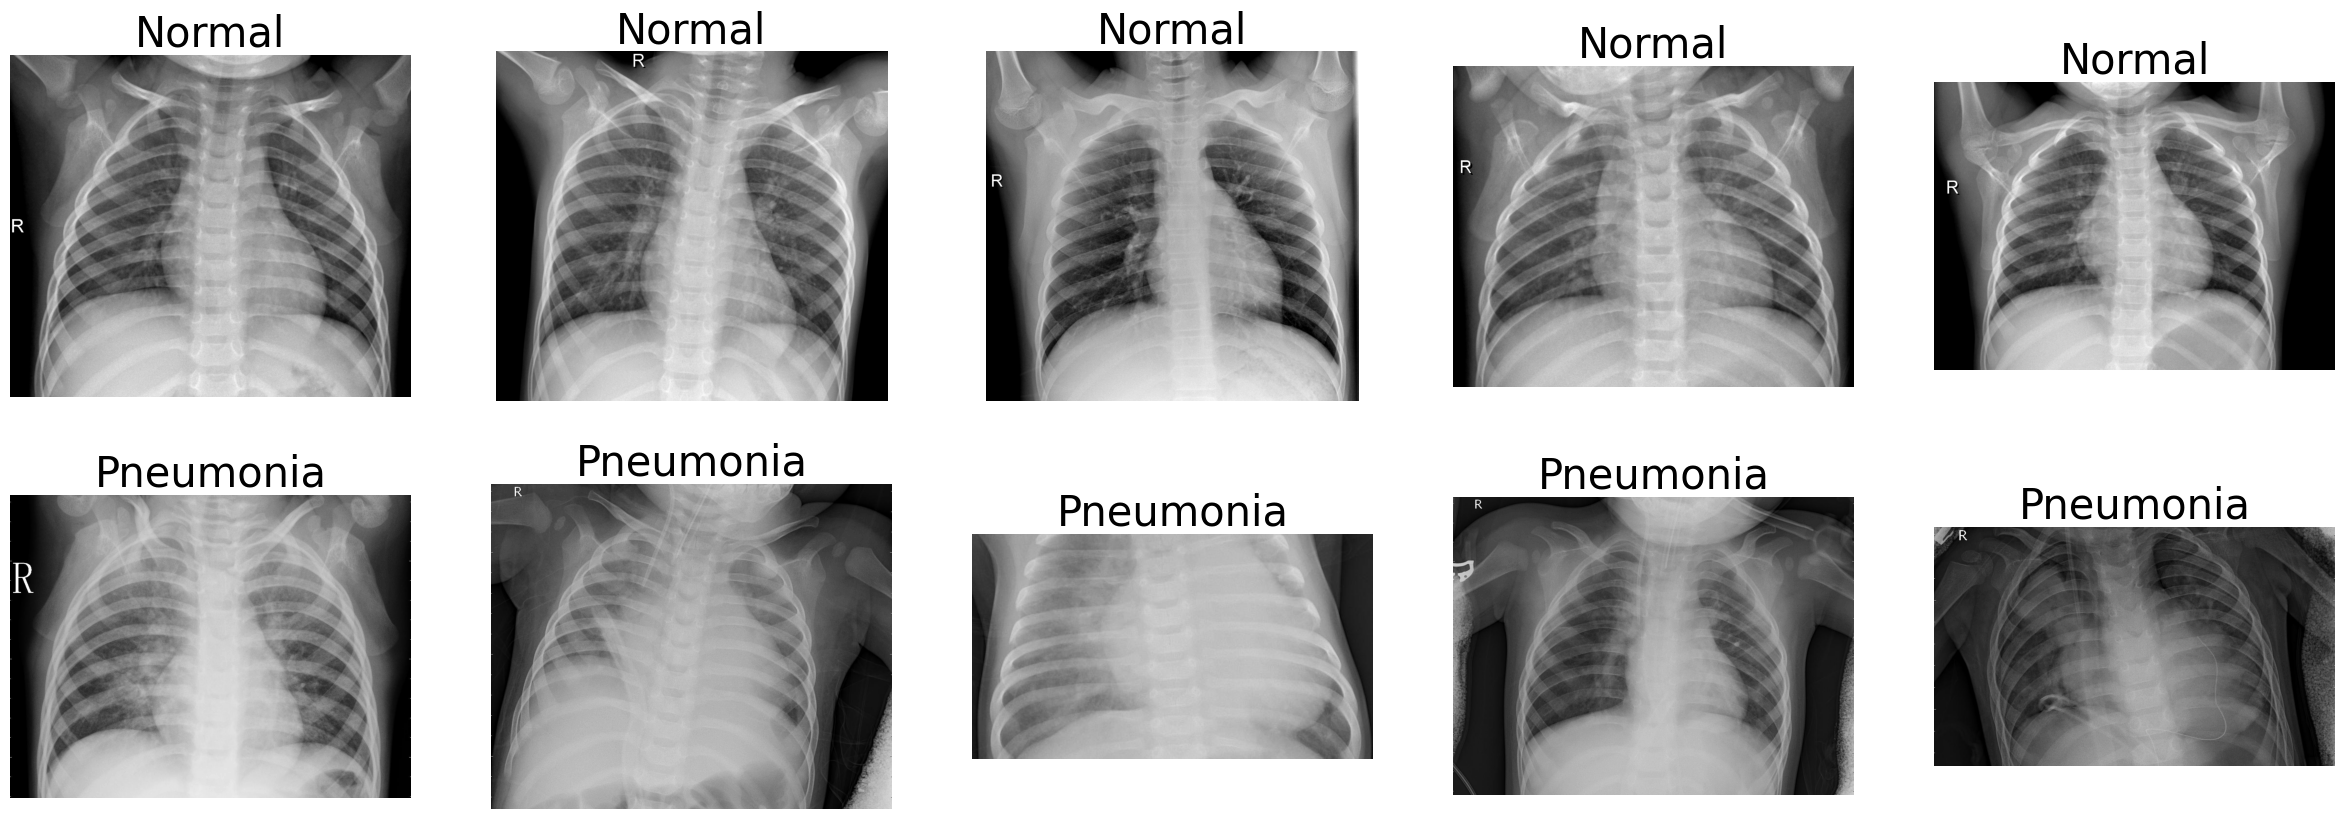

In [ ]:

fig, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,5):
    img = plt.imread(os.path.join(train_NORMAL_dir, train_NORMAL_fnames[i]))
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Normal', fontsize=30)
    
for i in range(0,5):
    img = plt.imread(os.path.join(train_PNEUMONIA_dir, train_PNEUMONIA_fnames[i]))
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title('Pneumonia', fontsize=30)
    
plt.show()

Comme vous pouvez le voir au dessus les images affiché non pas toute la même taille donc ce que je vais les afficher redimensionnées. C'est ce que je fait en dessous


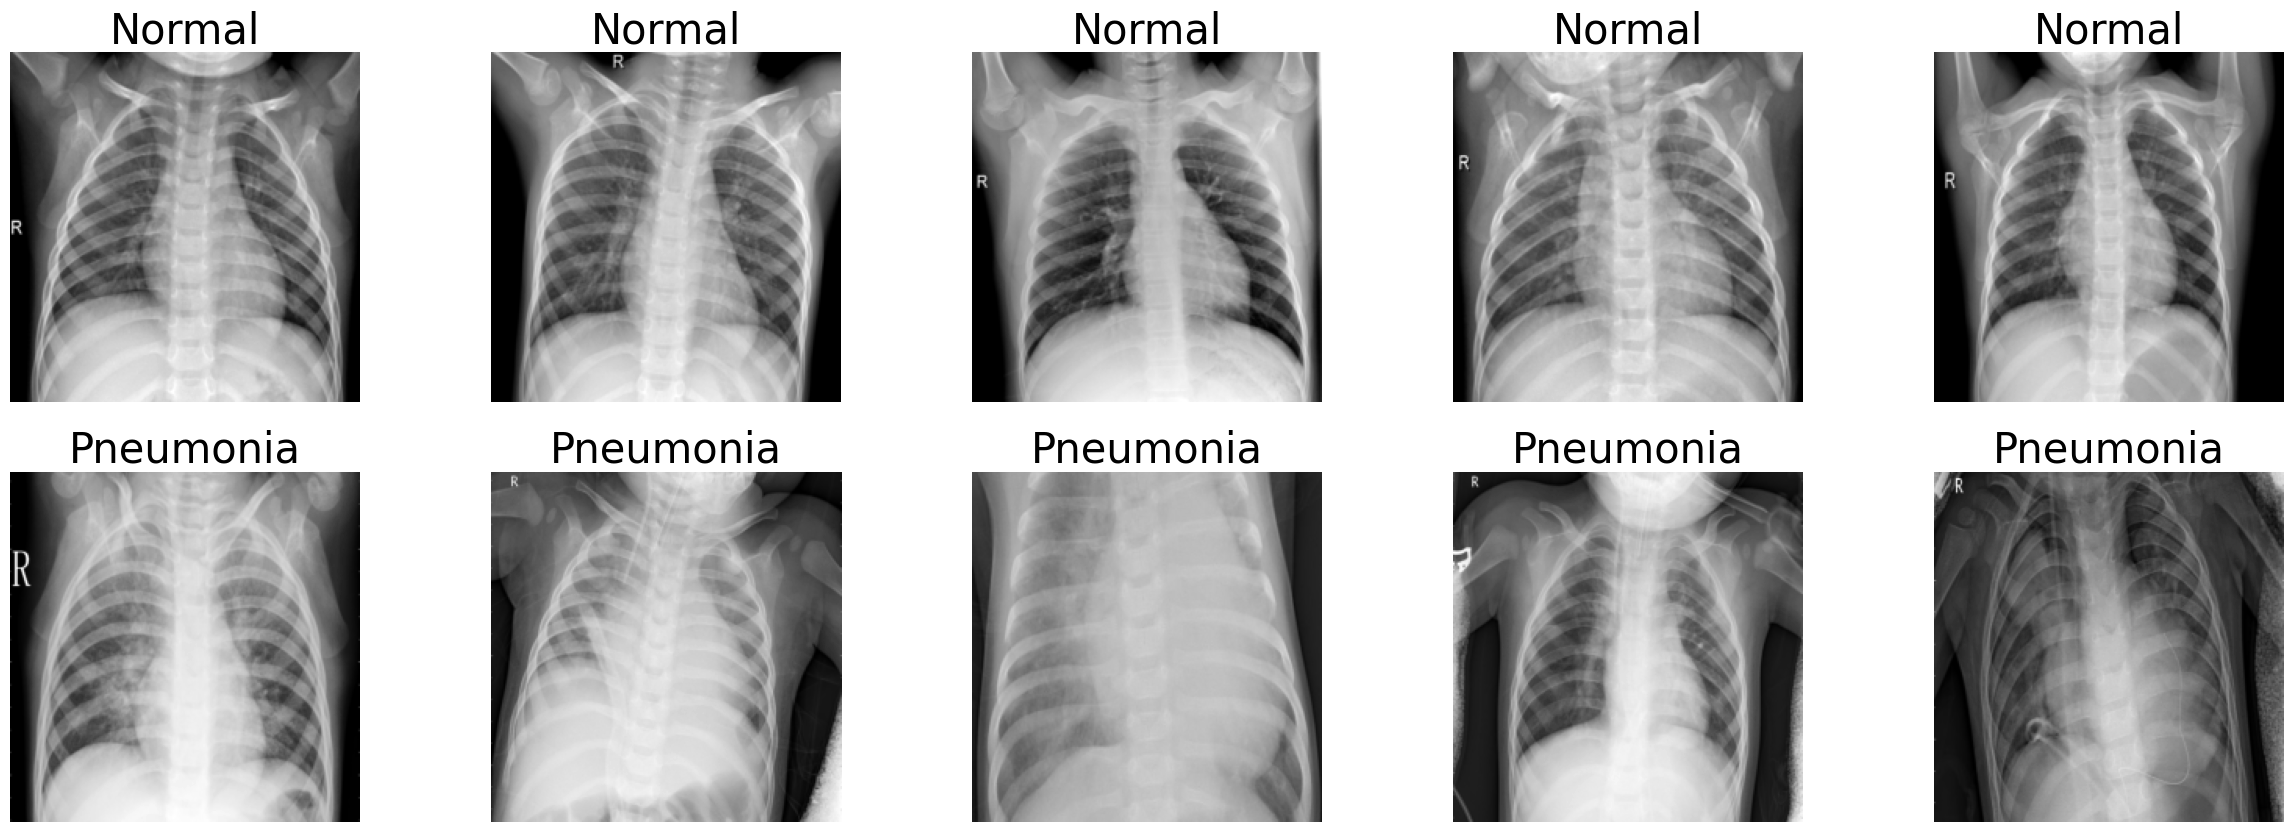

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(0,5):
    img = plt.imread(os.path.join(train_NORMAL_dir, train_NORMAL_fnames[i]))
    img = resize(img, (224, 224)) # redimensionner l'image
    ax[0,i].imshow(img, cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title('Normal', fontsize=30)
    
for i in range(0,5):
    img = plt.imread(os.path.join(train_PNEUMONIA_dir, train_PNEUMONIA_fnames[i]))
    img = resize(img, (224, 224)) # redimensionner l'image
    ax[1,i].imshow(img, cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title('Pneumonia', fontsize=30)

plt.show()

**Pré Processing**

J'utilise la bibliothèque de prétraitement d'images de Tensorflow pour extraire et générer des lots d'images à partir des dossiers (ImageDataGenerator).
Les images sont exprimées en valeurs RGB allant de 0 à 255, j'applique un facteur de mise à l'échelle de 1/255 aux images pour les normaliser afin qu'elles aient une valeur comprise entre 0 et 1.

J'applique une augmentation des données à la fois sur l'ensemble d'apprentissage et l'ensemble de validation afin d'évaluer les performances du modèle sur une distribution similaire d'images avec des augmentations similaires des données. Cependant, je n'applique pas d'augmentation sur les données tests afin d'évaluer les performances du modèle sur des images que le modèle serait plus susceptible de rencontrer dans des circonstances normales où l'image est moins susceptible d'être déformée


In [3]:


train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   samplewise_center=True, #un recentrage et une standardisation par échantillon pour centrer et standardiser les images
                                   samplewise_std_normalization=True, 
                                   zoom_range = 0.2, # on zoom de manière aléatoire sur les images qui sont généré
                                   width_shift_range=0.1,  #
                                   height_shift_range=0.1)

validation_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                         samplewise_center=True,
                                         samplewise_std_normalization=True, 
                                         zoom_range = 0.2, 
                                         width_shift_range=0.1,  
                                         height_shift_range=0.1)

test_datagen  = ImageDataGenerator(rescale = 1.0/255,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32, #La taille du lot (batch size) est fixée à 32, ce qui signifie que les paramètres internes du modèle seront mis à jour toutes les 16 échantillons qu'il a parcourus
                                                    class_mode='binary', # permet de donné des classes à nos répertoires
                                                    target_size=(224, 224) ) # On mets les images à une taille 224 par 224

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              target_size=(224, 224))

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# CNN MODEL

On utilise 4 blocs similaires de couches comprenant une couche de convolution suivie d'une normalisation par lots (batch normalization) et d'une couche de pooling (max pooling). Pour les couches de convolution à travers les 4 blocs, le nombre de filtres augmente de 32 à 128 avec une taille de noyau de 3x3.

Après la couche de convolution dans chaque bloc, j'applique une normalisation par lots pour normaliser les résultats. Ensuite, ils sont introduits dans la fonction d'activation relu. Ensuite, j'applique la couche de pooling avec une taille de regroupement de 2x2.

Après les 4 blocs de couches de convolution et de pooling, on rajoute une couche Dense avec 512 neurones, avec relu comme fonction d'activation. Enfin, j'inclus une couche de sortie avec 1 neurone utilisant la fonction sigmoïde comme fonction d'activation pour notre tâche de classification binaire.

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))



model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall') ])
history = model.fit(train_generator, 
          validation_data=validation_generator,
          epochs=40,
          verbose=1)
model.summary()


Epoch 1/40
163/163 [==============================] - 1566s 9s/step - loss: 0.7476 - accuracy: 0.8717 - recall: 0.9190 - val_loss: 43.7180 - val_accuracy: 0.5000 - val_recall: 1.0000
Epoch 2/40
163/163 [==============================] - 129s 791ms/step - loss: 0.2190 - accuracy: 0.9187 - recall: 0.9458 - val_loss: 7.8443 - val_accuracy: 0.5000 - val_recall: 1.0000
Epoch 3/40
163/163 [==============================] - 127s 778ms/step - loss: 0.1990 - accuracy: 0.9281 - recall: 0.9507 - val_loss: 10.0592 - val_accuracy: 0.5000 - val_recall: 1.0000
Epoch 4/40
163/163 [==============================] - 128s 785ms/step - loss: 0.1926 - accuracy: 0.9314 - recall: 0.9535 - val_loss: 1.4863 - val_accuracy: 0.5625 - val_recall: 1.0000
Epoch 5/40
163/163 [==============================] - 130s 796ms/step - loss: 0.1542 - accuracy: 0.9446 - recall: 0.9641 - val_loss: 1.3529 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 6/40
163/163 [==============================] - 132s 809ms/step - loss: 0.

# VGG16 Model

On utilise le model VGG16 qui est un modele pré entrainé sur un grand jeu de données appelé ImageNet.

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les poids des couches de base pour éviter leur mise à jour lors de l'entraînement permet de préserver les connaissances du modele et d'éviter le surajustement
# for layer in vgg16.layers:
#   layer.trainable = False

model = Sequential()

model.add(vgg16)

# Ajouter des couches supplémentaires pour la classification
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall') ])
history = model.fit(train_generator, 
          validation_data=validation_generator,
          epochs=40,
          verbose=1)
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/40
163/163 [==============================] - 782s 5s/step - loss: 1.4689 - accuracy: 0.7485 - recall: 0.9600 - val_loss: 1.6170 - val_accuracy: 0.5625 - val_recall: 0.8750
Epoch 2/40
163/163 [==============================] - 146s 892ms/step - loss: 0.2917 - accuracy: 0.8725 - recall: 0.9081 - val_loss: 1.4205 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 3/40
163/163 [==============================] - 142s 873ms/step - loss: 0.2289 - accuracy: 0.9047 - recall: 0.9267 - val_loss: 1.6177 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 4/40
163/163 [==============================] - 142s 866ms/step - loss: 0.2400 - accuracy: 0.8988 - recall: 0.9265 - val_loss: 0.6434 - val_accuracy: 0.6875 - val_recall: 0.8750
Epoch 5/40
163/163 [==============================] - 143s 879ms/step - loss: 0.1956 - accuracy: 0.9231 - recall: 0.9458 - val_loss: 2.3441 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 6/40
163/163

# Affichage des données

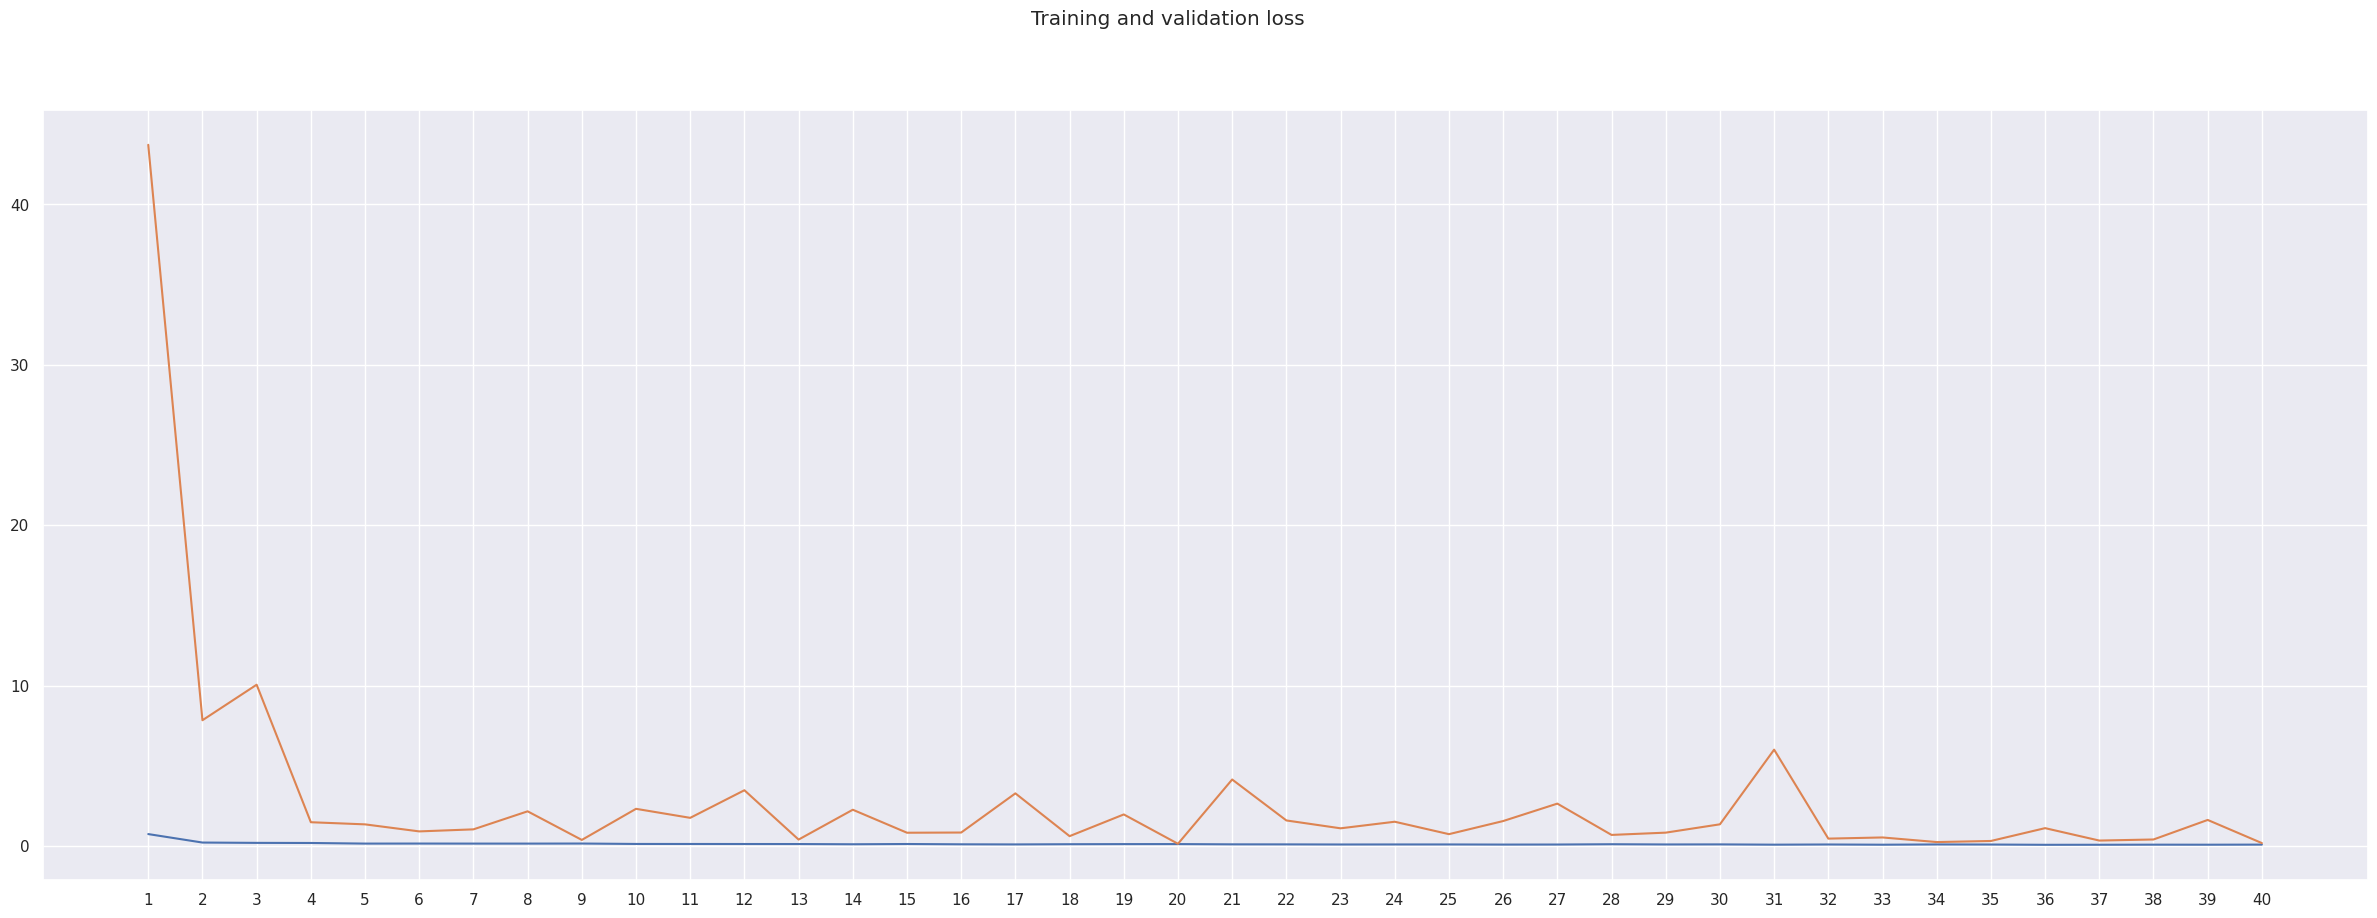

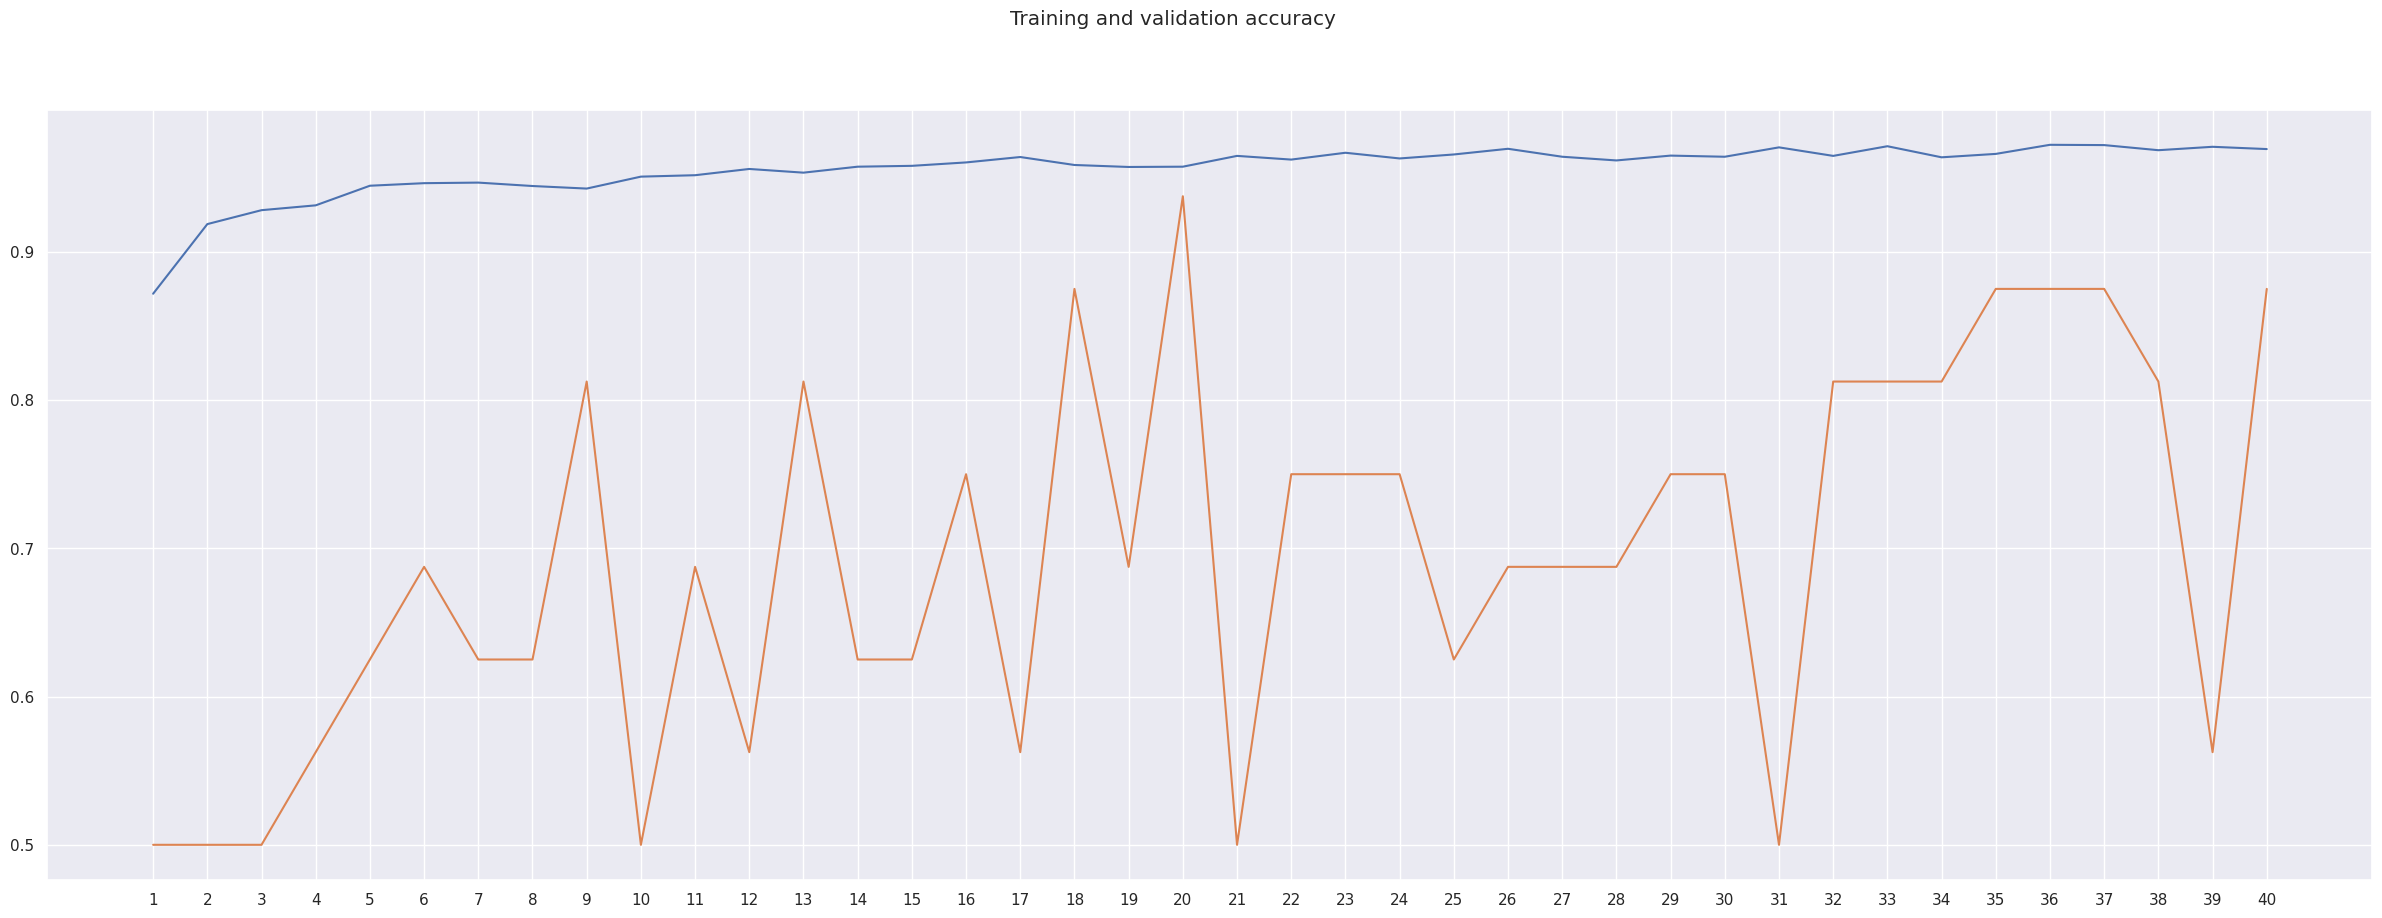

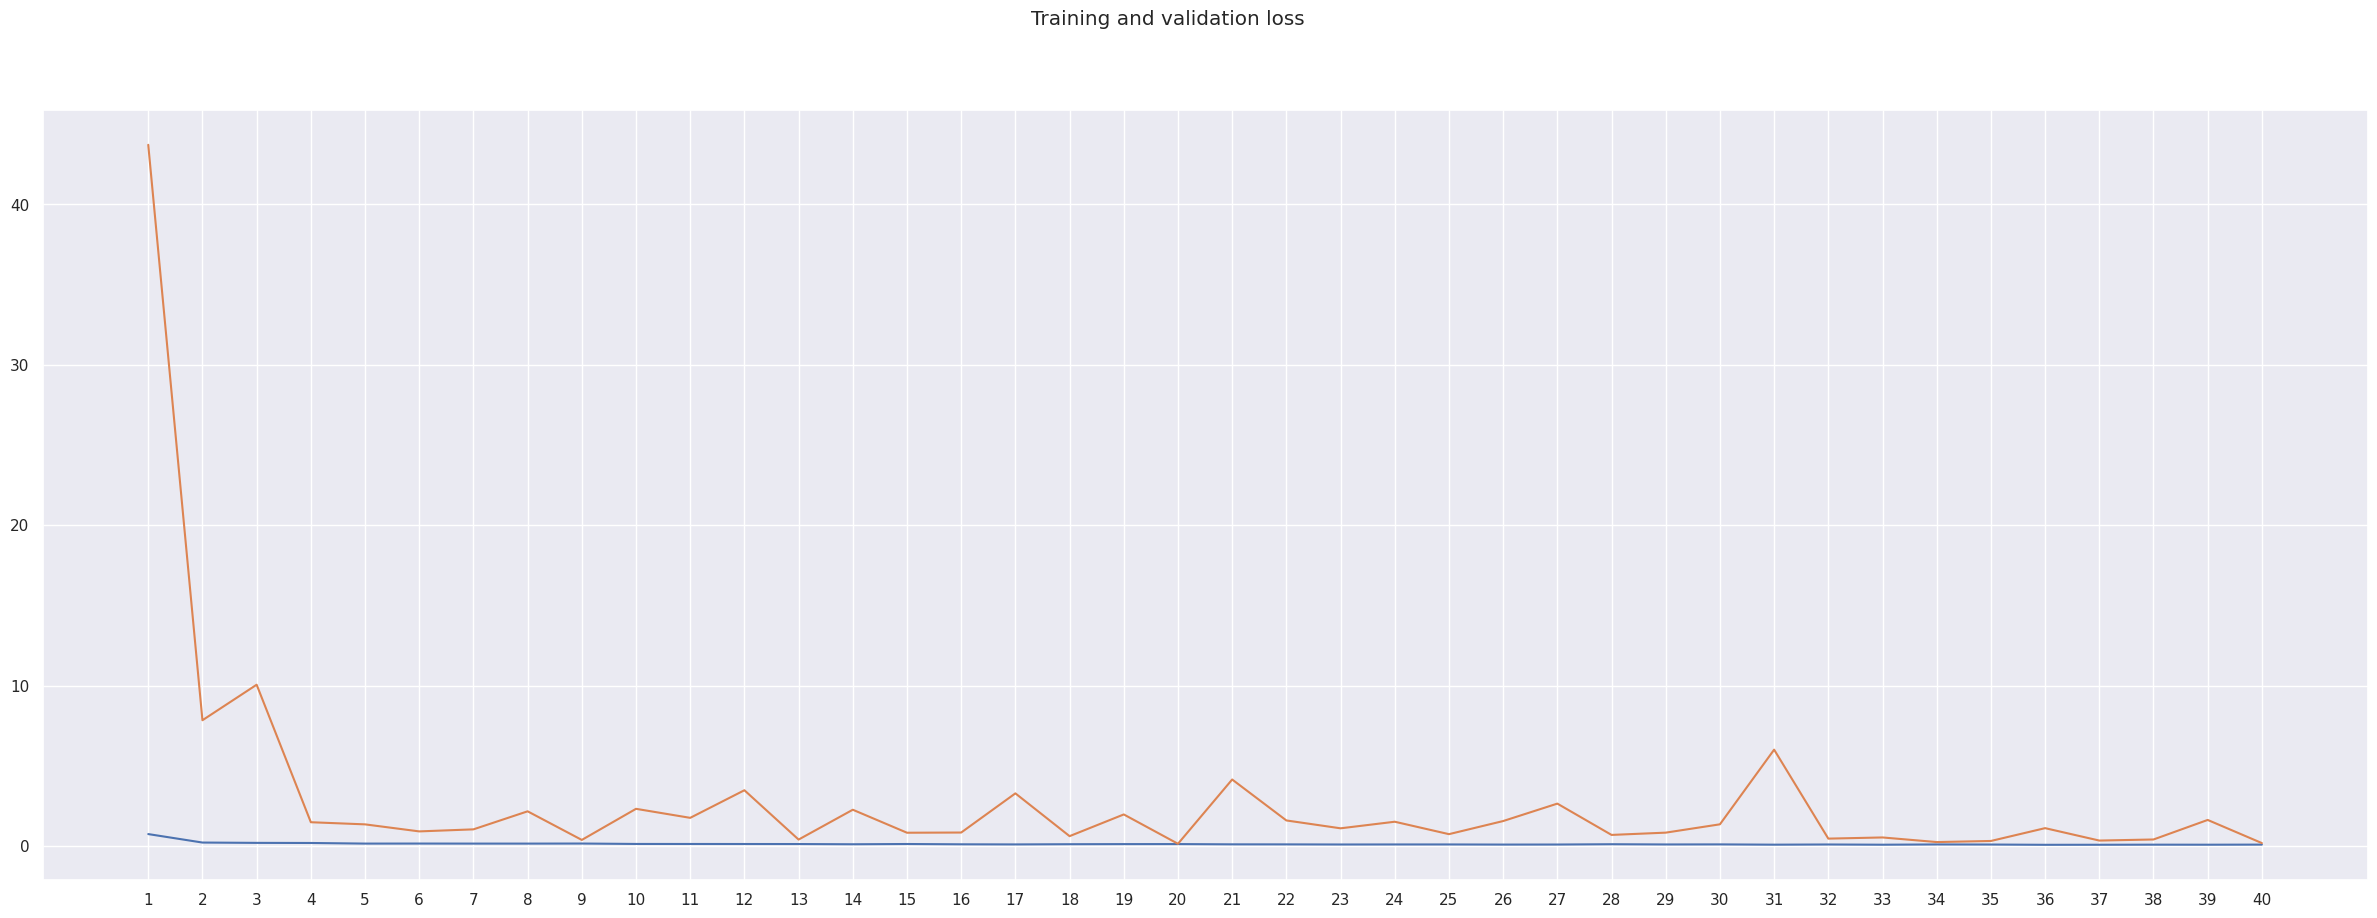

In [5]:
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



epochs = range(1, len(acc)+1) 

def metrics_charts(epochs, train_metrics, val_metrics, title):
    fig, axes = plt.subplots( figsize=(30,10))
    axes.plot(epochs, train_metrics)
    axes.plot(epochs, val_metrics)
    axes.set_xticks(np.arange(1, len(epochs)+1))
    fig.suptitle('Training and validation' + ' ' + title)
    return fig

metrics_charts(epochs, acc, val_acc, 'accuracy')
metrics_charts(epochs, loss, val_loss, 'loss')


La précision de l'ensemble d'apprentissage augmente à plus de 95 %. Nous pourrions être tentés de sauter à la conclusion que le modèle fait un très bon travail. Cependant, lorsque nous examinons le taux de précision dans l'ensemble de validation à travers les époques, il oscille entre 75 % et 90 % sans tendance claire à l'augmentation à mesure que nous entraînons le modèle à travers plusieurs époques.

La perte dans l'ensemble d'apprentissage a tendance à baisser, alors que celle dans la perte de validation ne montre pas de tendance claire à la baisse après les premières époques.

# Evaluation de notre Model sur les données tests
On l'accuracy de notre modele sur les données de test

In [6]:
evaluation = model.evaluate(test_generator)
test_acc=evaluation[1]
test_loss=evaluation[0]
print(f'Perte du modele: {test_loss:.4f}')
print(f'Précision du model: {test_acc:.4f}')

20/20 [==============================] - 226s 12s/step - loss: 0.2505 - accuracy: 0.9263 - recall: 0.9821
Perte du modele: 0.2505
Précision du model: 0.9263


# Prédiction

La matrice de confusion est une technique couramment utilisée pour évaluer les performances d'un modèle de classification. Elle permet de visualiser les prédictions du modèle par rapport aux vraies étiquettes des données.

**Matrix de Confusion**

20/20 [==============================] - 8s 386ms/step


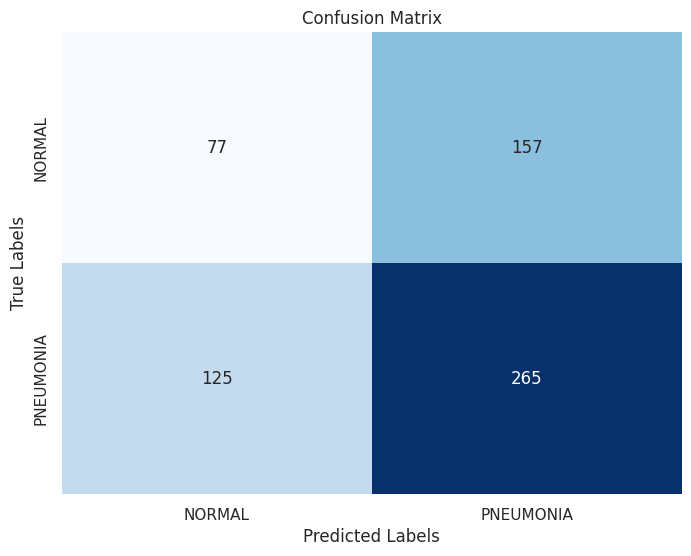

In [7]:
# Obtenir les prédictions du modèle sur les données de test
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)

# Obtenir les étiquettes réelles des données de test
true_labels = test_generator.classes

# Créer la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Définir les noms des classes
class_names = list(test_generator.class_indices.keys())

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# Obtenir les prédictions du modèle sur les données de test
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)

# Obtenir les étiquettes réelles des données de test
true_labels = test_generator.classes

# Générer le rapport de classification
report = classification_report(true_labels, predicted_labels)

# Afficher le rapport de classification
print(report)

20/20 [==============================] - 7s 328ms/step
              precision    recall  f1-score   support

           0       0.39      0.33      0.36       234
           1       0.63      0.68      0.66       390

    accuracy                           0.55       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.55      0.54       624

